In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Official Boise State colors - https://brandstandards.boisestate.edu/colors/
BoiseState_blue = '#0033A0'
BoiseState_orange = '#D64309'

aspect_ratio = 16./9

from scipy.odr import *
from scipy.optimize import curve_fit

194
Beta: [0.62591071 0.25631428]
Beta Std Error: [0.04460243 0.12306382]
Beta Covariance: [[ 28.93687834 -79.23060811]
 [-79.23060811 220.29036955]]
Residual Variance: 6.874882740626514e-05
Inverse Condition #: 0.03393132198695023
Reason(s) for Halting:
  Sum of squares convergence


Beta: [0.60358396]
Beta Std Error: [0.01385179]
Beta Covariance: [[2.66949979]]
Residual Variance: 7.187563098689876e-05
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence


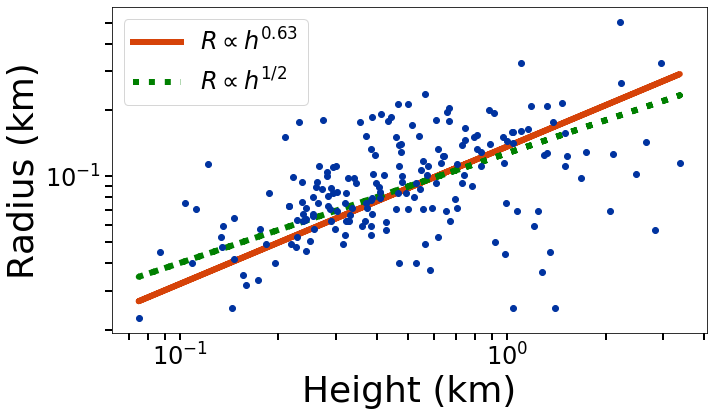

In [68]:
# Define a function to fit the data with.
def lin_func(p, x):
    m, c = p
    return m*x + c

def sqrt_func(c, x):
    return 0.5*x + c

fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax = fig.add_subplot(111)

data = np.genfromtxt("Stanzel2008_Table1_conditioned.txt", delimiter=",", names=True)
ind = ~np.isnan(data['Height'])
x = np.log10(data['Height'][ind])
y = np.log10(data['Diameter'][ind]/2)
x_unc = data['Height_unc'][ind]/(x*np.log(10.))
y_unc = data['Diameter_unc'][ind]/(y*np.log(10.))

print(x.size)

ax.loglog(data['Height']/1000., data['Diameter']/1000./2.,
            color=BoiseState_blue, marker='o', ls='')
ax.set_xlabel("Height (km)", fontsize=36)
ax.set_ylabel("Radius (km)", fontsize=36)
ax.tick_params(labelsize=24, which='both', width=2, length=7)

# Create a model for fitting.
lin_model = Model(lin_func)

# Create a RealData object using our initiated data from above.
model_data = RealData(x, y, sx=x_unc, sy=y_unc)

# Set up ODR with the model and data.
odr = ODR(model_data, lin_model, beta0=[0., 0.])

# Run the regression.
out = odr.run()

# Use the in-built pprint method to give us results.
out.pprint()

fit = lin_func(out.beta, x)
ax.loglog(data['Height'][ind]/1000., 10.**fit/1000., 
        color=BoiseState_orange, lw=6, zorder=-1, label="$R \\propto h^{%.2f}$" % out.beta[0])

# Force fit with square root
sqrt_model = Model(sqrt_func)
sqrt_odr = ODR(model_data, sqrt_model, beta0=[0.])
sqrt_out = sqrt_odr.run()
print("\n")
sqrt_out.pprint()
sqrt_fit = sqrt_func(sqrt_out.beta, x)

ax.loglog(data['Height'][ind]/1000., 10.**sqrt_fit/1000., 
        lw=6, ls=':', color='green', zorder=-1, label="$R \\propto h^{1/2}$")

ax.legend(loc='best', fontsize=24)

fig.savefig("Fit_to_Stanzel_data.png", dpi=500, bbox_inches="tight")

In [61]:
data = np.genfromtxt("Stanzel2008_Table1_conditioned.txt", delimiter=",", names=True)
ind = ~np.isnan(data['Height'])
x = np.log10(data['Height'][ind])
y = np.log10(data['Diameter'][ind]/2.)

# Arbitrarily increasing uncertainties
x_unc = data['Height_unc'][ind]/(x*np.log(10.))
y_unc = 2.4*data['Diameter_unc'][ind]/(y*np.log(10.))

# Create a model for fitting.
lin_model = Model(lin_func)

# Create a RealData object using our initiated data from above.
model_data = RealData(x, y, sx=x_unc, sy=y_unc)

# Set up ODR with the model and data.
odr = ODR(model_data, lin_model, beta0=[0., 0.])

# Run the regression.
out = odr.run()

# Use the in-built pprint method to give us results.
out.pprint()

Beta: [0.50152183 0.61326966]
Beta Std Error: [0.04082231 0.11160982]
Beta Covariance: [[  76.16462171 -206.65151727]
 [-206.65151727  569.32846755]]
Residual Variance: 2.1879726364035717e-05
Inverse Condition #: 0.03410807582052046
Reason(s) for Halting:
  Sum of squares convergence


0.08612339374557976 0.17137819171492186


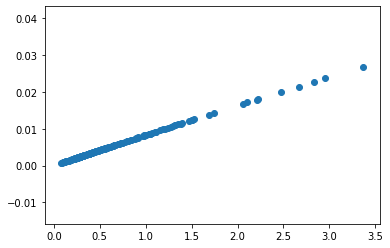

In [4]:
# 2019 Aug 21 - Exploring the predicted thermodynamic efficiency using numbers from Renno+ (2000)
def efficiency(num_scale_height, chi=0.22):
    return 1. - (1. - np.exp(-(chi + 1.)*num_scale_height))/((1. - np.exp(-num_scale_height))*(chi + 1.))

scale_height = 13000.

num_scale_heights = data['Height']/scale_height
efficiencies = efficiency(num_scale_heights)

plt.scatter(data['Height']/1000., efficiencies)
print(efficiency(1.), efficiency(4.))

/Users/brian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


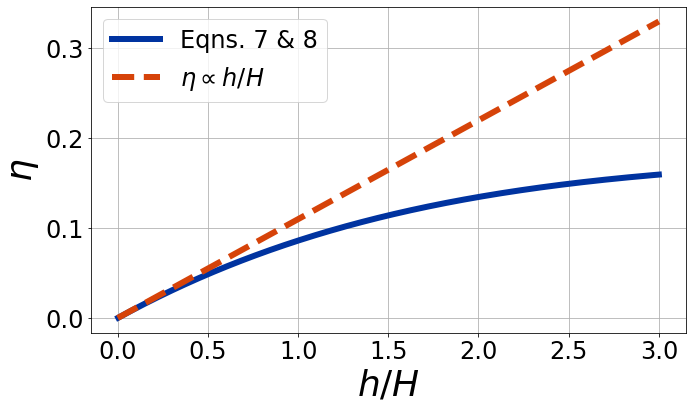

In [18]:
hypothetical_num_scale_heights = np.linspace(0, 3, 1000)
hypothetical_efficiencies = efficiency(hypothetical_num_scale_heights)

chi = 0.22

fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax = fig.add_subplot(111)

ax.plot(hypothetical_num_scale_heights, hypothetical_efficiencies, 
        lw=6, color=BoiseState_blue, label="Eqns. 7 & 8")
ax.plot(hypothetical_num_scale_heights, 0.5*chi*hypothetical_num_scale_heights, 
        lw=6, ls='--', color=BoiseState_orange, label="$\\eta \\propto h/H$")
ax.set_xlabel("$h/H$", fontsize=36)
ax.set_ylabel("$\\eta$", fontsize=36)
ax.tick_params(labelsize=24)
ax.grid(True)
ax.legend(loc='best', fontsize=24)

fig.savefig("eta_vs_h-over-H.png", dpi=500, bbox_inches="tight")

[0.6564406  1.19375171]
[0.0907752  0.20587875]


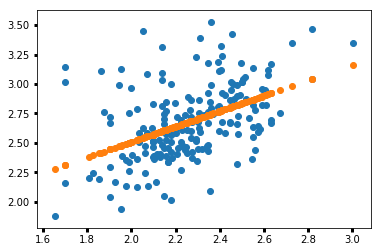

In [59]:
# plt.errorbar(data['Diameter'], data['Height'], xerr=data['Diameter_unc'], yerr=data['Height_unc'], ls='')
# plt.scatter(data['Diameter'], data['Height'])

ind = ~np.isnan(data['Height'])
# x = np.log10(data['Diameter'][ind])
# y = np.log10(data['Height'][ind])
# y_unc = data['Height_unc'][ind]/(y*np.log(10.))

x = np.log10(data['Diameter'][ind])
y = np.log10(data['Height'][ind])
y_unc = data['Height_unc'][ind]/(y*np.log(10.))

p, p_err = np.polyfit(x, y, 1, cov=True)
print(p)
print(np.sqrt(p_err.diagonal()))
plt.scatter(x, y)
plt.scatter(x, np.polyval(p, x))